### 23. juni

Fikk satt sammen de ulike kodene til et eget script som jeg kan forsette å redigere. Prøver å hente ut vektene for å kunne sammenligne vektendring med accuracy og tid. Fikk plottet grafer for accuracy vs epochs, loss vs epochs, vektdifferanse vs epoch og accuracy vs vektdifferanse.

Litt mer om nettverk for min egen del:

### Hva er et nevralt nettverk?

Et nevralt nettverk er i korte trekk en funksjon som tar inn visse verdier og gir oss forventede verdier ut igjen. Nettverkene er bygd oppp som følger:
- Input lag: Det første laget i nettverket som er hvor man sender inn data fra dataset. Antallet nevroner i laget er det samme som antallet piksler i bildene. Input laget regnes ikke med som et av lag i nettverket da det ikke er noe databehandling (computation) i dette laget.
- Skjulte lag: Lagene mellom input- og output-laget kalles skulte lag (hidden layers). Det kan være flere skulte lag og jo flere man har, jo mer komplekst er nettverket.
- Output lag: Verdiene i dette laget er de som til sist brukes til å gjøre en prediction
- Nevroner: Hvert lag er bygget opp av et visst antall nevroner og hvert nevron er tilknyttet alle de andre nevronene i laget før og etter.
- Aktiveringsfunksjon: Transformerer den vektede summen til hvert nevron til en verdi mellom 0 og 1.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision

In [3]:
# Hyperparameters
num_epochs = 10 # Antall epoker
hidden_dim1 = 100
hidden_dim2 = 50
batch_size = 64 # Størrelsen på hver batch
learning_rate = 0.01 
input_size = 28**2 # Input str.: datasettet inneholder bilder av str 28x28 pixls
output_size = 10 # Output str. ønsker tall fra 0-9

Laster ned MNIST-datasettet fra Pytorch. Ett treningssett for å trene opp nettverket og så et testsett for å teste nettverket med bilder det ikke har sett før. Treningssettet består av 60 000 bilder av str. 28x28 pikseler og testsettet består av 10 000 bilder av samme størrelse.

In [4]:
# Loads the MNIST dataset from Pytorch
train_set = torchvision.datasets.MNIST('data', train=True, transform=transforms.ToTensor(), download=True)
test_set = torchvision.datasets.MNIST('data', train=False, transform=transforms.ToTensor(), download=True)

Fra treningssettet og testsettet kan man hente ut images og labels hvor images er bildene som settet består av med tilhørende labels som forteller hvilket tall som er på bildet.

For å teste hvordan settet ser ut velger jeg et tilfeldig bilde og visualiserer det. I tillegg printer jeg ut tilhørende label til bildet for å se at bildet og label stemmer overens.

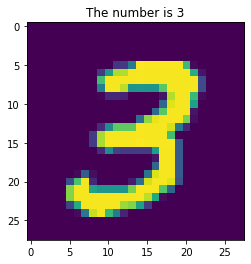

In [5]:
# Ser hvordan datasettet ser ut
plt.imshow(train_set.data[7])
plt.title(f"The number is {train_set.targets[7]}")
plt.show()

Jeg definerer klassen Data som initialiserer bildene og tilhørende labels og gjør at vi kan finne lengden av dem og indexere dem.

In [6]:
class Data(Dataset):
    def __init__(self, dataset):
        self.x, self.y = dataset.data, dataset.targets
        self.x = self.x / 255.0
        # self.y = F.one_hot(self.y, num_classes=10).to(float) # = 10 siden tall fra 0-9

    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

Lager en instans av Data-klassen med trening- og testsettet.

In [7]:
train_ds = Data(train_set)
test_ds = Data(test_set)

Definerer en loader for begge settene slik at vi kan sende dataen gjennom nettverket i batches. En batch er en liten del av det totale antallet bilder.

In [8]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

For å se hvordan dataen i dataloaderen ser ut printer jeg ut formen. Vi ser at antallet bilder og tilhørende labels har gått fra 60 000 til 5. Hvor 5 er batch størrelse.

In [9]:
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 28, 28])
torch.Size([64])


In [10]:
xs, ys = train_ds[0:4]
ys.shape

torch.Size([4])

Når vi definerer antall lag i et nevralt nettverk regner vi ikke med input-laget slik at nettverket under har kun tre lag, ikke fire.

ReLU er en aktiveringsfunksjon som er bundet mellom 0 og $\infty$. For verdier mindre eller lik 0 returnerer funksjonen 0 og for verdier større enn 0 returnerer funksjonen input verdien. Den er derfor en lineær funksjon fra og med 0.

In [11]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__() # initialiserer nn.Module
        self.layer1 = nn.Linear(input_size, hidden_dim1) # Definerer 1. hidden layer
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2) # Definerer 2. hidden layer
        self.layer3 = nn.Linear(hidden_dim2, output_size) # Definerer output layer
        self.R = nn.ReLU() # Definerer aktiveringsfunksjonen

    def forward(self, x):
        """
        Implementerer feed-forward-metoden
        """
        x = self.R(self.layer1(x))
        x = self.R(self.layer2(x))
        x = self.layer3(x)
        return x  # .squeeze() 

In [12]:
model = NeuralNet()

### Stochastic gradient descent (SDG)

SGD tar inn alle parametrene til nettverket og læringsraten

In [13]:
# Definerer loss og optimizer funksjonene
optimizer = SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [14]:
# Lager test-data for å ta i bruk lengre nede i loopen.
x_test = test_set.data.reshape(-1, input_size).float()
y_test = test_set.targets

In [15]:
# Lager lister for å lagre epochs, loss, accuracy og gj.snittlig vektendring for hver epoch
epochs = []
losses = []
accuracy = []
# Liste for å lagre gjenomsnittlig vektendring over alle lagene for hver epoch
avg_weight_changes = []


# Create a copy of the initial model state
initial_state = copy.deepcopy(model.state_dict())
# Create dictionaries to store the weight differences for each layer
# The weight difference is between one epoch and the next
layer_weight_differences = {layer_name: [] for layer_name, _ in model.named_parameters()}

# Create dictionaries to store the highest valued weights for each layer
prev_highest_weights = {layer_name: None for layer_name, _ in model.named_parameters()}
current_highest_weights = {layer_name: None for layer_name, _ in model.named_parameters()}


# Create dictionaries to store the weight differences between the highest weights for each layer.
# This weight difference is also between one epoch and the next.
highest_weight_differences = {layer_name: [] for layer_name, _ in model.named_parameters()}


for epoch in range(num_epochs):
    # Train the model
    N = len(train_dl)
    model.train()

    for i, (x_batch, y_batch) in enumerate(train_dl):
        # Updates the weights and biases of the network
        optimizer.zero_grad() 
        x_batch = x_batch.reshape(-1, input_size)
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch) # Computes the loss
        loss.backward()
        optimizer.step() # Performs iteration using gradient above
        # Stores the training data
        epochs.append(epoch+i/N)
        losses.append(loss.mean().item())

    # Evaluate the model
    model.eval()
    # Calculate actual output
    output = model(x_test)
    # Compare actual output with expected output
    acc = (torch.argmax(output, 1) == y_test).float().mean()
    accuracy.append(acc.item())
    print(f"Epoch {epoch}, loss {loss}, accuracy {acc*100}")

    total_weight_change = 0
    total_weights = 0

    # Caluculate weight difference for each layer
    for layer_name, layer_weights in model.named_parameters():
        # select only weights and not the biases
        if "weight" in layer_name:
            # Define the previous weights
            prev_weights = initial_state[layer_name]
            # Define current weights
            current_weights = layer_weights.data
            difference = torch.abs(current_weights - prev_weights)
            # Calculate weight change in each layer
            layer_weight_differences[layer_name].append(difference.mean().item())

            # Calculate average weight change for all the layers
            weight_change = torch.abs(current_weights - prev_weights).sum().item()
            total_weight_change += weight_change
            total_weights += current_weights.numel() # returns total number of elements in tensor

    average_weight_change = total_weight_change / total_weights
    avg_weight_changes.append(average_weight_change)

    # Calculate highest weight difference for each layer
    for layer_name, layer_weights in model.named_parameters():
        if "weight" in layer_name:
            if prev_highest_weights[layer_name] is not None:
                prev_highest = prev_highest_weights[layer_name].max()
                current_highest = layer_weights.max()
                highest_weight_difference = current_highest - prev_highest
                highest_weight_differences[layer_name].append(highest_weight_difference.item())

            prev_highest_weights[layer_name] = current_highest_weights[layer_name]  # Update previous highest weights
            current_highest_weights[layer_name] = layer_weights.detach().clone() # creates a copy of the weights detatched from the gradient computations

    
    # Update initial state for the next epoch
    initial_state = copy.deepcopy(model.state_dict())
    

Epoch 0, loss 1.1470634937286377, accuracy 75.8800048828125
Epoch 1, loss 0.4374450147151947, accuracy 86.83999633789062
Epoch 2, loss 0.3596479296684265, accuracy 89.49000549316406
Epoch 3, loss 0.2839077413082123, accuracy 90.31999969482422
Epoch 4, loss 0.3405506908893585, accuracy 91.40999603271484
Epoch 5, loss 0.35313355922698975, accuracy 91.27999877929688
Epoch 6, loss 0.0675279051065445, accuracy 91.91999816894531
Epoch 7, loss 0.2179766297340393, accuracy 91.54000091552734
Epoch 8, loss 0.2889637053012848, accuracy 93.01000213623047
Epoch 9, loss 0.2847239673137665, accuracy 92.97000122070312


In [16]:
# Turning lists to arrays for flexibility
epochs = np.array(epochs)
losses = np.array(losses)
accuracy = np.array(accuracy)
average_weight_changes = np.array(avg_weight_changes)

In [17]:
# Reshaping before plotting to get same dimentions
epoch_data_avgd = epochs.reshape(num_epochs, -1).mean(axis=1)
loss_data_avgd = losses.reshape(num_epochs, -1).mean(axis=1)
accuracy = accuracy.reshape(num_epochs, -1).mean(axis=1)

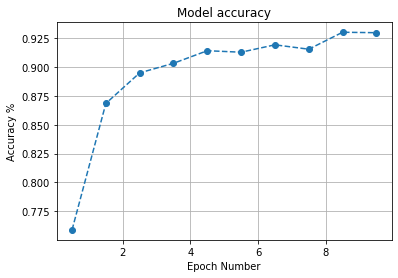

In [18]:
plt.plot(epoch_data_avgd, accuracy,"o--")
plt.grid()
plt.title("Model accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy %")
plt.show()

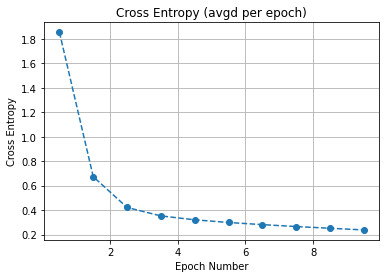

In [19]:
plt.plot(epoch_data_avgd, loss_data_avgd, "o--")
plt.grid()
plt.xlabel("Epoch Number")
plt.ylabel("Cross Entropy")
plt.title("Cross Entropy (avgd per epoch)")
plt.show()

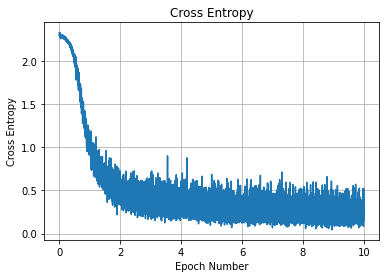

In [20]:
plt.plot(epochs, losses)
plt.grid()
plt.xlabel("Epoch Number")
plt.ylabel("Cross Entropy")
plt.title("Cross Entropy")
plt.show()

In [21]:
""" 
Calculating total accuracy of whole model
"""
with torch.no_grad():
    n_correct = 0
    n_samp = 0
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.reshape(-1, 28**2)
        y_pred = model(x_batch)
        _, predicted = torch.max(y_pred.data, 1)
        n_samp += y_batch.size(0)
        n_correct += (predicted == y_batch).sum().item()
    acc = 100.0 * n_correct / n_samp
    print(n_samp)
    print(f"Accuracy of the network on the 60000 test images: {acc} %") 

10000
Accuracy of the network on the 60000 test images: 93.61 %


Vi ser at total accuracy stemmer overens med accuracy til modellen etter siste epoch utregnet og printet litt lengre oppe. 

tensor(4)

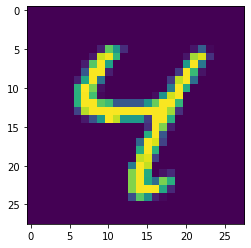

In [22]:
# Tester at modellen funker og gir forventet output med test-dataen.
x_sample = test_ds[6][0]
y_sample = test_ds[6][1]
plt.imshow(x_sample)
x_sample = x_sample.view(-1, 28**2)
yhat_samp = model(x_sample)
torch.argmax(yhat_samp)

Leste til slutt litt om hvordan man kan implementere gradvis læring av et nettverk. Fant et eksempel med CIFAR10-datasettet.

### 24. juni

Leste litt mer om CIFAR10, men så fort at det var et datasett med helt andre typer bilder enn de håndtegnede sifrene i MNIST-datasettet. 

Lagde et par plot av vektendring som vist under.

Begynte å lese litt på artikkelen Self-Organised Learning in the Chialvo-Bak Model av Marco Brigham. Leste og WTA og synaptic depression.

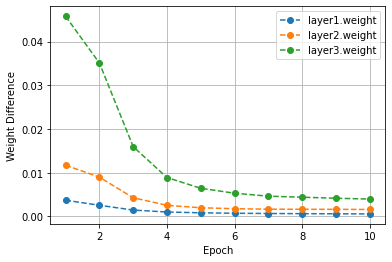

In [23]:
# Get the max number of weight differences across all layers
max_weight_differences = max(len(weight_differences) for weight_differences in layer_weight_differences.values())

# Generate the x-axis epoch data
epoch_data_avgd = np.linspace(1, num_epochs, max_weight_differences)

# Plot epoch vs. weight difference for each layer
for layer_name, weight_differences in layer_weight_differences.items():
    if "weight" in layer_name:
        plt.plot(epoch_data_avgd[:len(weight_differences)], weight_differences, "o--", label=layer_name)

plt.xlabel("Epoch")
plt.ylabel("Weight Difference")
plt.grid()
plt.legend()
plt.show()

Ser at det er størst endring i vektene i det 3. laget i nettverket. Dette laget er mye mindre enn det første laget. Som definert i starten av dokumentet er antall input-noder 28^2, det første skjulte laget har 100 noder, det andre skjulte laget har 50 noder og out-putlaget har 10 noder. Input-laget regnes ikke som et eget lag i nevrale nettverk.

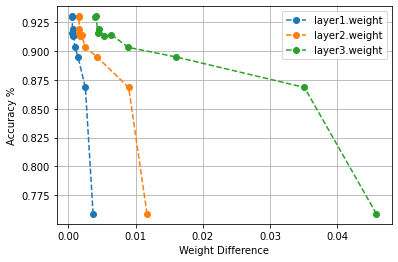

In [24]:
# Plot the weight difference for each layer vs accuracy of model
for layer_name, weight_differences in layer_weight_differences.items():
    if "weight" in layer_name:
        plt.plot(weight_differences, accuracy, "o--", label=layer_name)

plt.xlabel("Weight Difference")
plt.ylabel("Accuracy %")
plt.grid()
plt.legend()
plt.show()

Ser at ettersom vektdifferansen blir mindre øker riktigheten til modellen.

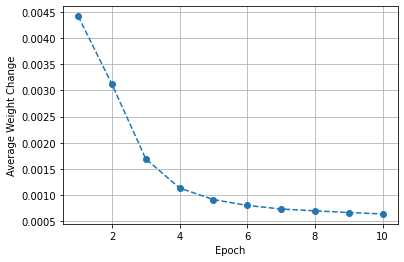

In [25]:
# Plot the average weight change for all layers vs epochs
plt.plot(epoch_data_avgd, average_weight_changes, "o--")

plt.xlabel('Epoch')
plt.ylabel('Average Weight Change')
plt.grid()
plt.show()

Begynte også på et script for gradvis læring av et nettverk som finnes i 26-27_06_23.ipynb

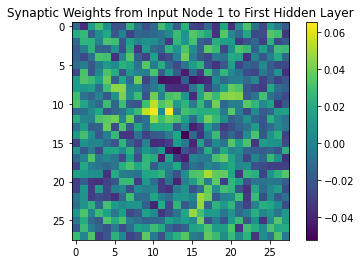

In [26]:
weights = model.layer1.weight.data  # Get the weights of layer1
weights_input1 = weights[0].reshape(28, 28)  # Extract weights corresponding to input node 1

# Reshape the weights to match the input size if needed
weights_input1 = weights_input1.reshape(28, 28)

plt.imshow(weights_input1)
plt.title("Synaptic Weights from Input Node 1 to First Hidden Layer")
plt.colorbar()
plt.show()

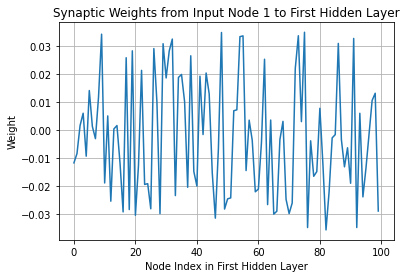

In [27]:
weights = model.layer1.weight.data  # Get the weights of layer1
weights_input1 = weights[:, 0]  # Extract weights corresponding to input node 1

plt.plot(range(hidden_dim1), weights_input1)
plt.title("Synaptic Weights from Input Node 1 to First Hidden Layer")
plt.xlabel("Node Index in First Hidden Layer")
plt.ylabel("Weight")
plt.grid()
plt.show()

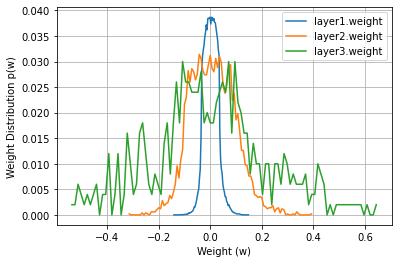

In [33]:
# Plot weight distribution vs weight for each layer
for layer_name, layer_weights in model.named_parameters():
    if "weight" in layer_name:
        weights = layer_weights.data.flatten().numpy()
        weight_range = np.linspace(weights.min(), weights.max(), num=100)
        weight_distribution = np.zeros_like(weight_range)

        # Calculate the weight distribution
        for weight in weights:
            weight_distribution[np.abs(weight_range - weight).argmin()] += 1

        weight_distribution /= len(weights)  # Normalize the weight distribution

        plt.plot(weight_range, weight_distribution, label=layer_name)

plt.xlabel('Weight (w)')
plt.ylabel('Weight Distribution p(w)')
plt.legend()
plt.grid()
plt.show()

Prøvde meg også på å plotte vektdifferansen mellom hver epoke for vektene med størst verdi i hvert lag. Dette ga et uventet resultat, noe jeg tror skyldes for like variabelnavn i koden ovenfor. Kommer tilbake til dette senere.

Kom tilbake til det 07.07.23 og fant at det jeg hadde plottet ikke var det jeg faktisk ville plotte. Under viser korrekt plott:

In [1]:
# Get the max number of weight differences across all layers
max_weight_differences = max(len(weight_differences) for weight_differences in highest_weight_differences.values())

# Generate the x-axis epoch data
epoch_data_avgd = np.linspace(1, num_epochs, max_weight_differences)

# Plot epoch vs. weight difference for each layer
for layer_name, weight_differences in highest_weight_differences.items():
    if "weight" in layer_name:
        plt.plot(epoch_data_avgd[:len(weight_differences)], weight_differences, "o--", label=layer_name)

plt.xlabel("Epoch")
plt.ylabel("Weight Difference")
plt.title("Weight differences for highest-valued weights in each layer")
plt.grid()
plt.legend()
plt.show()

NameError: name 'highest_weight_differences' is not defined

Sammenligner vi vektendringen i plottet ovenfor med plottet for gjennomsnitlig vektendring i hvert lag, ser vi at i dette siste plottet er endringen mye større, spesielt for vekten i lag 3.

Årsaken til at endringen i vektene med allerede størst verdi er større er nok fordi før treningen vil vektene være langt fra korrekte og denne vekten må endres en del for å få korrekt verdi. Som vi ser i 06_07_23.ipynb ser vi at de fleste vektene endres veldig lite som vi også kan se i plottet for gjennomsnitlig vektendring i hvert lag. Vektene i plottet ovenfor er derfor av de få som endres mye. Om dette gjelder i alle tilfeller må undersøkes videre.